# Modelo predictivo valor EUR/USD- Reto 3

## ➡️ Contexto

*NUWE EVA* es una cadena de restaurantes innovadora y disruptiva que emplea robots para realizar todas las tareas humanas. Además de esta característica única, también buscan diferenciarse de los demás restaurantes en la forma en que asignan los precios a su carta. Han decidido vincular los precios del menú a las fluctuaciones del mercado de divisas, específicamente en el valor *EUR/USD*.

Si bien esta estrategia de pricing tiene el potencial de atraer a muchos comensales curiosos, también presenta un riesgo significativo para la estabilidad del negocio debido a la imprevisibilidad de los ingresos.

## 📄 Dataset

Para este reto tendréis dos archivos descargables: un `training_set.csv` y `testing_set.csv`. El primero se debe emplear para el entrenamiento del modelo, y el segundo para introducirlo como input a tu modelo y entregar las predicciones. Abajo los parámetros que hay tener en cuenta:

* `Time`: Indica la fecha y hora en la que se registró el precio del par de divisas EUR/USD. Esto es fundamental para analizar las fluctuaciones y tendencias del mercado en diferentes períodos de tiempo.

* `Open`: Representa el precio de apertura del par EUR/USD en el período de tiempo especificado. Es el primer precio registrado al comienzo de dicho intervalo, como una hora, un día o una semana.

* `High`: Muestra el precio más alto alcanzado por el par EUR/USD durante el período de tiempo analizado. Este valor es útil para identificar los niveles de resistencia en el análisis técnico.

* `Low`: Refleja el precio más bajo alcanzado por el par EUR/USD en el período de tiempo estudiado. Este valor es relevante para determinar los niveles de soporte en el análisis técnico.

* `Close`: Indica el precio de cierre del par EUR/USD en el período de tiempo especificado. Es el último precio registrado antes de que finalice dicho intervalo, proporcionando una idea de cómo terminó la sesión de negociación.

* `Volume`: Muestra la cantidad de unidades de EUR/USD negociadas durante el período. El volumen puede ayudar a identificar la fuerza de una tendencia o confirmar la validez de un movimiento de precios.

* `Label`: Es la clase que les permitirá predecir ciertas dinámicas del mercado, permitiéndoles así estimar los márgenes de beneficio que tendrán en sus menús con antelación. Esta será la variable que se tendrá que predecir en el dataset de test.

## 🎯 Objetivo
Crea un modelo predictivo de clasificación para poder entender las dinámicas de movimiento del *EUR/USD*, únicamente en base a valores del pasado y presente y por último integra el uso de *APEX* en el mismo.
1. Realiza un análisis exploratorio de los datos empleando *APEX*.
2. Crea un modelo predictivo que maximice la puntuación F1-score (macro). Entrenando tu modelo con el dataset de training (trainig_test.csv), y efectuando las predicciones sobre el dataset de testing (testing_set.csv).
3. Crea una presentación (máx 9 slides) con la siguiente estructura:
* Portada.
* Análisis exploratorio de los datos:
    - Resumen y visualizaciones clave.
* Preprocesamiento de los datos:
    - Pasos principales y criterios utilizados.
* Modelos y técnicas de predicción:
    - Modelos seleccionados y justificación.
* Entrenamiento, validación y resultados:
    - Proceso y métricas principales.
* Conclusiones.
Se pueden usar fuentes de datos externas para la resolución del reto, como por ejemplo datos históricos de tweets, noticias, etc.

**IMPORTANTE**:

Hay que tener cuidado de no incurrir en el look-ahead bias. Esto será penalizado. El modelo solo puede utilizar valores actuales `t` o pasados `(t-1,...t-n)` como elementos predictivos. Si el modelo emplea datos futuros, es decir `t+n`, el modelo estaría accediendo a información futura, por lo que la predicción no será válida.

**EJEMPLO**:

Para predecir el label del día 18 de Mayo de 2018, el modelo tan solo podrá usar las variables de predicción referentes al 18 de Mayo de 2018 y de los días previos (17,16,15... de Mayo de 2018).

In [1]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 0. Importacion del Dataset

In [2]:
''' load data '''
train = pd.read_csv('../Data/train.csv',index_col = [0], parse_dates = ['Time'])
test = pd.read_csv('../Data/test.csv',index_col = [0], parse_dates = ['Time'])

In [3]:
# Display the first 5 rows of the training dataset to inspect the data
train.head()

,Time,Open,High,Low,Close,Volume,label
train_idx,,,,,,,
0,2007-03-07,1.31258,1.31844,1.31086,1.31648,1807377.0,0
1,2007-03-08,1.31667,1.31813,1.31154,1.31396,1995920.0,1
2,2007-03-09,1.31396,1.31583,1.30864,1.31118,1859100.0,1
3,2007-03-11,1.31236,1.31415,1.31068,1.31175,192381.0,1
4,2007-03-12,1.31193,1.31992,1.31054,7.90878,2009286.0,1


In [4]:
# Display the last 5 rows of the training dataset to inspect the data
train.tail()

,Time,Open,High,Low,Close,Volume,label
train_idx,,,,,,,
3504,2018-05-18,1.18053,1.18221,1.17498,1.17689,220609.0,1
3505,2018-05-20,1.17684,1.17756,1.17441,1.17474,18855.0,0
3506,2018-05-21,1.17473,1.17973,1.17165,1.17913,227861.0,0
3507,2018-05-22,1.17914,1.18296,1.17567,1.17824,255729.0,0
3508,2018-05-23,1.17825,1.17877,1.16758,1.17069,316034.0,0


In [5]:
test.head()

,Time,Open,High,Low,Close,Volume
test_idx,,,,,,
0,2018-05-29,1.16271,1.16394,1.15099,1.15343,336090
1,2018-05-30,1.15342,1.16759,1.15186,1.16627,318421
2,2018-05-31,1.16627,1.17243,1.16410,1.16938,285788
3,2018-06-01,1.16937,1.17178,1.16170,1.16584,253533
4,2018-06-03,1.16561,1.16794,1.16561,1.16757,14803


In [6]:
# values of the target
train.label.value_counts() # balanced

0    1755
1    1754
Name: label, dtype: int64

In [7]:
# Display the data types of each column in the train dataframe
train.dtypes

Time      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
label              int64
dtype: object

# 1. Exploratory Data Analysis

In [8]:
''' shape of the data '''
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (3509, 7)
test shape: (1500, 6)


In [9]:
''' missing values train '''
# calculate the number of missings and the %
pd.DataFrame([train.isna().sum(),train.isna().sum()*100/train.shape[0]],index = ['conteo missing','% missings']).T

,conteo missing,% missings
Time,0.0,0.000000
Open,18.0,0.512967
High,56.0,1.595896
Low,67.0,1.909376
Close,39.0,1.111428
Volume,28.0,0.797948
label,0.0,0.000000


In [10]:
''' duplicated values '''
print(f'valores duplicados en train: {train.duplicated().sum()}')
print(f'valores duplicados en test: {test.duplicated().sum()}')

valores duplicados en train: 0
valores duplicados en test: 0


## 1.1. Numeric Data Exploration

In [11]:
''' distribution of the numeric variables '''
# Call the describe method on the train dataset to get a summary of its numerical variables.
# The T method transposes the output to display the summary statistics horizontally instead of vertically.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3491.0,1.315917,0.463695,0.136331,1.181970,1.313140,1.376900,1.260450e+01
High,3453.0,1.308379,0.361848,0.133119,1.184600,1.318720,1.381560,1.152279e+01
Low,3442.0,1.298522,0.367142,0.133926,1.176797,1.307255,1.372110,1.087128e+01
Close,3470.0,1.309465,0.406838,0.132743,1.181277,1.313005,1.376593,1.087704e+01
Volume,3481.0,279384.302253,299512.522504,497.000000,81228.000000,191209.000000,269974.000000,2.693602e+06
label,3509.0,0.499858,0.500071,0.000000,0.000000,0.000000,1.000000,1.000000e+00


In [12]:
cols = ['Open','Close','High','Low']
for col in cols:
    train[col] = train[col].apply(lambda x: nan if (x>1.7) or (x<1) else x)

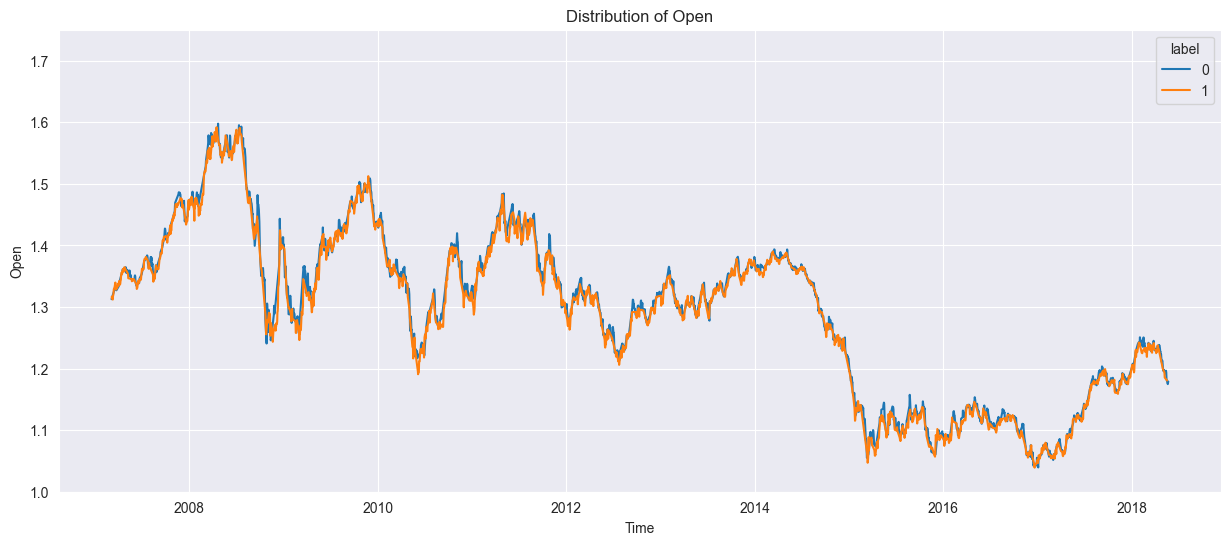

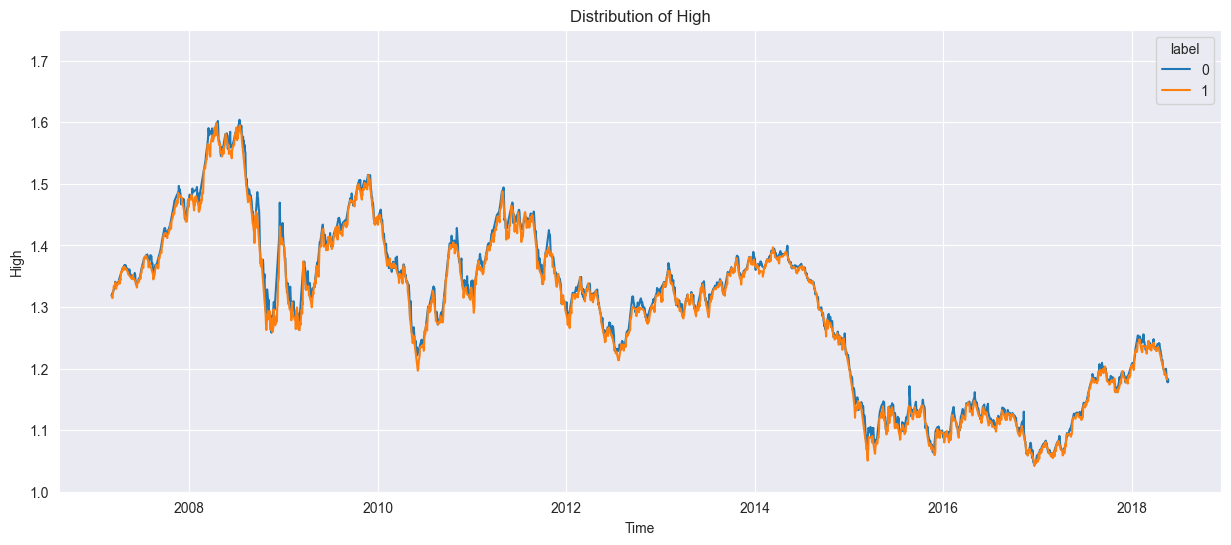

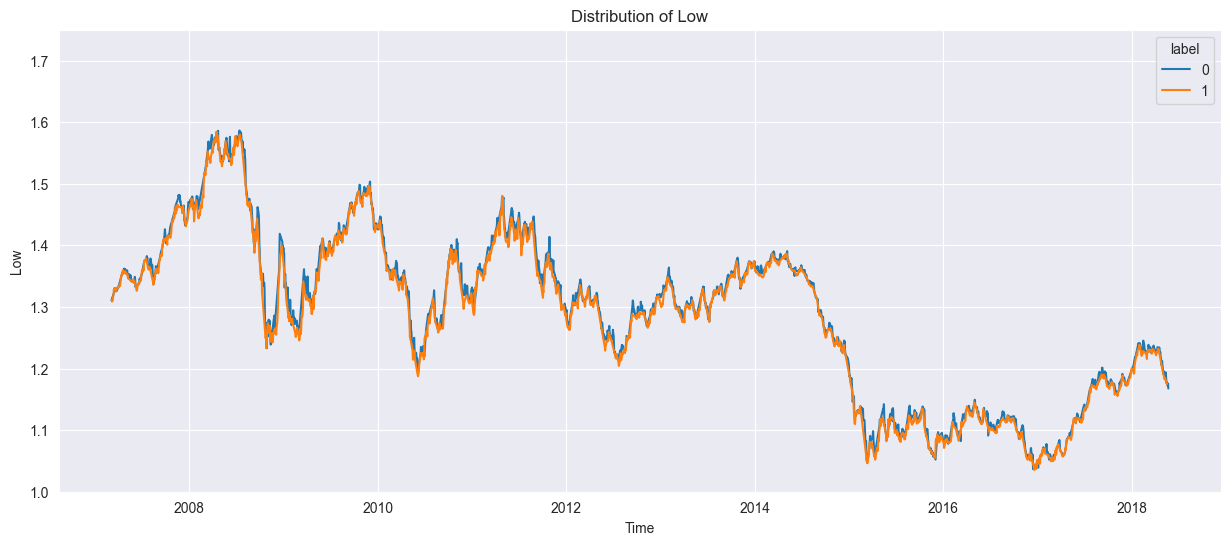

In [ ]:
''' graphical distribution of the numeric variables '''
# select numerical columns
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
for i in numerical_cols:
    if (i != 'label'):
        plt.figure(figsize=(15,6))
        ax = sns.lineplot(data = train, x = 'Time' , y = i, hue = 'label')
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        if (i != 'Volume'):
            plt.ylim(1,1.75)
        plt.show()

# 2. Handle missing Values

Como tenemos un bajo porcentaje de valores missing, los imputamos usando `KNNImputer`

In [ ]:
def imputer(train):
    # impute the rest of the variables
    knn = KNNImputer(n_neighbors=int(sqrt(train.shape[0])), weights= 'distance', metric= 'nan_euclidean')
    # I have to tell him that the reference columns for the nearest neighbors
    # must be numeric, although it can be fine-tuned.
    Train = pd.DataFrame(knn.fit_transform(train.drop(['Time'],axis=1)), columns = train.drop(['Time'],axis=1).columns)
    Train['Time'] = train['Time']
    cols = Train.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    Train = Train[cols]
    for x in Train.columns:
        Train[x]=Train[x].astype(train[x].dtypes.name)
    return Train

In [ ]:
train = imputer(train)
train.head()

# 2. Feature Engineering

Algunas técnicas de feature engineering que se pueden aplicar al caso de Quantitative Trading:

* Indicadores técnicos: se pueden utilizar indicadores técnicos comunes, como el promedio móvil (MA), la banda de Bollinger, el índice de fuerza relativa (RSI), entre otros, para medir la tendencia y la volatilidad del mercado. Estos indicadores pueden proporcionar información importante sobre la dirección futura del precio.
* Transformaciones de series de tiempo: es posible aplicar transformaciones matemáticas a las series de tiempo de los precios y otros indicadores, como la diferenciación, la integración, la suavización y la descomposición en componentes. Estas transformaciones pueden mejorar la detección de patrones y la predicción del precio.
* Variables macroeconómicas: las variables macroeconómicas, como las tasas de interés, la inflación y el crecimiento económico, pueden afectar el precio de los activos financieros. Es posible incluir estas variables como features en el modelo para capturar estas relaciones.

## 2.1. Indicadores Técnicos

In [ ]:
def get_sma(prices, rate):
    ''' calculates standard moving average '''
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    ''' calculates rollinger band '''
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

def get_volatility(prices,rate=20):
    ''' calculates volatility '''
    sma = get_sma(prices, rate)
    return prices.diff().rolling(rate).std()

def get_rsi(prices, rate=20):
    ''' calculates RSI '''
    delta = prices.diff()
    delta = delta[1:] # because we used diff
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(rate).mean()
    avg_loss = loss.rolling(rate).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

## 2.2. Transformaciones de series de tiempo

In [ ]:
def integrate(data):
    ''' calculates integration '''
    integrated_data = data.cumsum()
    return integrated_data

def differentiate(data):
    ''' calculates differentation between values of a time series '''
    differentiated_data = data.diff()
    return differentiated_data

def smooth(data, window_size=5):
    ''' calculates '''
    smoothed_data = data.rolling(window_size).mean()
    return smoothed_data

def decompose(data, periodo=365):
    ''' This function uses the statsmodels library to perform
    a seasonal decomposition of the time series into its trend,
    seasonal, and residual components. The result is three time
    series representing each of these components. '''
    decomposition = seasonal_decompose(data, model='multiplicative', period=periodo)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend, seasonal, residual

In [ ]:
def generate_features(data,windows = [10,20,40,60,120]):
    # first we generate the tehcnical indicators:
    for win in windows:
        column_name = f'MA_{win}'
        data[column_name] = get_sma(data['Close'],win)
        column_name1 = f'RB_{win}_up'
        column_name2 = f'RB_{win}_down'
        data[column_name1],data[column_name2] = get_bollinger_bands(data['Close'],win)
        column_name = f'volatility_{win}'
        data[column_name] = get_volatility(data['Close'],win)
        column_name = f'rsi_{win}'
        data[column_name] = get_rsi(data['Close'],win)
    # then we generate some time series transformations:
    columns = ['Open','Close','High','Low','Volume']
    for column in columns:
        column_name = f'{column}_integrate'
        data[column_name] = integrate(data[column])
        column_name = f'{column}_differentiate'
        data[column_name] = differentiate(data[column])
        column_name = f'{column}_smooth'
        data[column_name] = smooth(data[column], window_size= 10)
        column_name1 = f'{column}_trend'
        column_name2 = f'{column}_seasonal'
        column_name3 = f'{column}_residual'
        data[column_name1], data[column_name2], data[column_name3] = decompose(data[column])
    return data

In [ ]:
train = generate_features(train)
train = imputer(train)

test = generate_features(test)
test = imputer(test)

In [ ]:
def separatetime(df):
    # we separate the timestamp to 3 columns: day-month-year
    df['day'] = df.Time.dt.day
    df['month'] = df.Time.dt.month
    df['year'] = df.Time.dt.year
    cols = df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    df = df[cols]
    return df

In [ ]:
train = separatetime(train)
test = separatetime(test)

In [ ]:
def Transformer(train,test):
    # we define the numerical cols of the dataframe
    numerical_cols = [cname for cname in train.drop(['day','month','year'],axis=1).columns if train[cname].dtype in ['int64', 'float64']]
    #yeo = PowerTransformer(method='yeo-johnson')
    sc = StandardScaler()
    # Pipeline for numericals
    num_pipe = Pipeline(steps=[('scaler',sc)]) # estandarize
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(transformers=[
            ('num',num_pipe, numerical_cols)])
    # this is just to eliminate the prefix 'num' and 'cat' of the variables
    preprocessor.fit(train)
    names = []
    for i in preprocessor.get_feature_names_out():
        names.append(i[5:])
    # we finally save the preprocessing in the dataframe we're gonna use to make the models
    Train = pd.DataFrame(preprocessor.fit_transform(train), columns = names)
    Train[['day','month','year','Time']] = train[['day','month','year','Time']]
    cols = Train.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    Train = Train[cols]
    Test = pd.DataFrame(preprocessor.transform(test), columns = names)
    Test[['day','month','year','Time']] = test[['day','month','year','Time']]
    cols = Test.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    Test = Test[cols]
    return Train,Test

In [ ]:
Xtrain, Xtest = Transformer(train.drop(['label'], axis=1), test)
Xtrain['label'] = train.label

In [ ]:
Xtrain.head()

In [ ]:
xtrain, xtest = Xtrain[Xtrain.year <= 2017].drop(['Time'],axis = 1), Xtrain[Xtrain.year > 2017].drop(['Time'],axis = 1)
ytrain = xtrain.pop('label')
ytest = xtest.pop('label')

In [ ]:
rf = RandomForestClassifier(random_state=99)

rf.fit(xtrain, ytrain)
print(f'classification report RandomForest:')
print(classification_report(ytest, rf.predict(xtest)))

In [ ]:
rf = RandomForestClassifier(random_state=99)
xgb = XGBClassifier()
gb = GradientBoostingClassifier(random_state=99 )
rf.fit(Xtrain.drop(['Time','label'],axis=1),Xtrain['label'])
xgb.fit(Xtrain.drop(['Time','label'],axis=1),Xtrain['label'])
gb.fit(Xtrain.drop(['Time','label'],axis=1),Xtrain['label'])

df = pd.DataFrame(zip(Xtrain.columns,rf.feature_importances_), columns = ['features','rf'] )
df2 = pd.DataFrame(zip(Xtrain.columns,xgb.feature_importances_), columns = ['features','xgb'] )
df3 = pd.DataFrame(zip(Xtrain.columns,gb.feature_importances_), columns = ['features','gb'])
df = df.merge(df2, left_on= 'features', right_on='features')
df = df.merge(df3, left_on= 'features', right_on='features')
df.sort_values(by = ['rf','xgb','gb'], ascending= False)

In [ ]:
Xtrain[df.sort_values(by = ['rf','xgb','gb'], ascending= False).features.iloc[:15]]

In [ ]:
dataT = Xtrain[df.sort_values(by = ['rf','xgb','gb'], ascending= False).features.iloc[:3]]
datat = Xtest[df.sort_values(by = ['rf','xgb','gb'], ascending= False).features.iloc[:3]]
rf.fit(dataT,Xtrain['label'])
predictions = pd.DataFrame(rf.predict(datat),columns= ['target'])
predictions.to_json(r'./Data/Results/predictions.json') # 0.5004 score